In [8]:
import os
import glob
import numpy as np
import xarray as xr
import dask
import cftime
import nc_time_axis
import subprocess
import matplotlib.pyplot as plt
import osprey_actions as osa
import osprey_eof as ose
import osprey_tools as ost
import osprey_io as osi

In [9]:
expname='lfr0'
var='thetao'
ndim='3D'
endleg=21 
yearspan=10
yearleap=10

In [10]:
dirs = osi.folders(expname)
startleg = ost.get_startleg(endleg, yearspan)
startyear = ost.get_year(startleg)
endyear = ost.get_year(endleg)
window = endyear - startyear
foreyear = ost.get_forecast_year(endyear, yearleap)
fdate = cftime.DatetimeGregorian(foreyear, 7, 1, 12, 0, 0, has_year_zero=False)
foredate = xr.DataArray(data = np.array([fdate]), dims = ['time'], coords = {'time': np.array([fdate])}, attrs = {'stardand_name': 'time', 'long_name': 'Time axis', 'bounds': 'time_counter_bnds', 'axis': 'T'})

In [11]:
pattern = xr.open_mfdataset(os.path.join(dirs['tmp'], str(endleg).zfill(3), f"{var}_pattern_{startyear}-{endyear}.nc"), use_cftime=True, preprocess=ose.preproc_pattern_3D)
field = pattern.isel(time=0)*0
for i in range(window):        
    filename = os.path.join(dirs['tmp'], str(endleg).zfill(3), f"{var}_timeseries_{startyear}-{endyear}_0000{i}.nc")
    timeseries = xr.open_mfdataset(filename, use_cftime=True, preprocess=ose.preproc_timeseries_3D)        
    p = timeseries.polyfit(dim='time', deg=1, skipna = True)
    theta = xr.polyval(foredate, p[f"{var}_polyfit_coefficients"])
    laststep = pattern.isel(time=i)
    field = field + theta.isel(time=0,lat=0,lon=0)*laststep

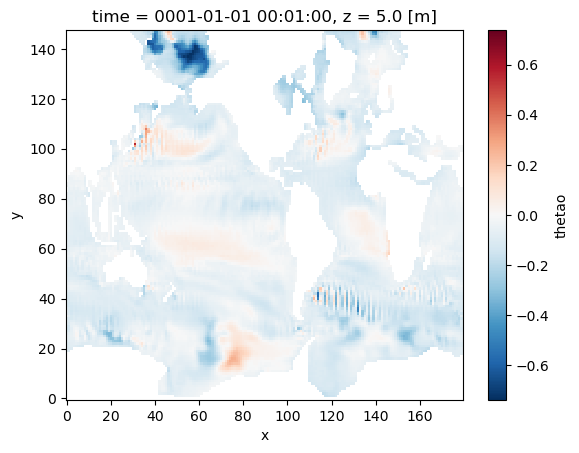

In [12]:
#delta = field_all - field_one
field['thetao'].isel(z=0).plot()

(10, 10000)

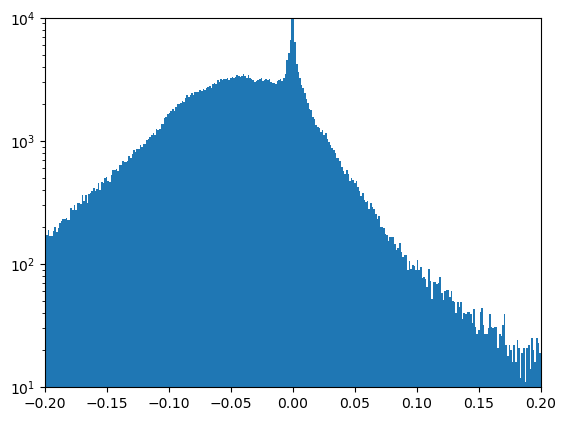

In [13]:
#plt.hist(field_all['thetao'].values.flatten(), bins=1000)
plt.hist(field['thetao'].values.flatten(), bins=1000)
plt.yscale('log')
plt.xlim(-0.2,0.2)
plt.ylim(10,10000)

In [14]:
field['thetao']

<xarray.DataArray 'thetao' (z: 31, y: 148, x: 180)> Size: 7MB
dask.array<add, shape=(31, 148, 180), dtype=float64, chunksize=(1, 148, 180), chunktype=numpy.ndarray>
Coordinates:
    time     object 8B 0001-01-01 00:01:00
    lon      (y, x) float32 107kB dask.array<chunksize=(148, 180), meta=np.ndarray>
    lat      (y, x) float32 107kB dask.array<chunksize=(148, 180), meta=np.ndarray>
  * z        (z) float32 124B 5.0 15.0 25.0 35.01 ... 4.25e+03 4.75e+03 5.25e+03
Dimensions without coordinates: y, x

In [17]:
# Convert the field to a NumPy array
field_data = field['thetao'].values
# Compute the FFT of the field along each dimension
fft_result = np.fft.fftn(field_data, axes=(0, 1, 2))
# Compute the power spectrum (magnitude squared of the FFT)
power_spectrum = np.abs(fft_result) ** 2
# Compute the frequencies corresponding to the FFT result
freq_x = np.fft.fftfreq(field_data.shape[2])
freq_y = np.fft.fftfreq(field_data.shape[1])
freq_z = np.fft.fftfreq(field_data.shape[0])

# Shift the zero frequency component to the center
power_spectrum_shifted = np.fft.fftshift(power_spectrum)
freq_x_shifted = np.fft.fftshift(freq_x)
freq_y_shifted = np.fft.fftshift(freq_y)
freq_z_shifted = np.fft.fftshift(freq_z)

# Average power spectrum over perpendicular directions (x and y)
power_spectrum_avg = np.mean(power_spectrum_shifted, axis=(0, 1))

# Corresponding frequencies for the 1D spectrum (taking only one direction)
freq_1d = freq_z_shifted

# Plot the 1D power spectrum
#plt.figure(figsize=(10, 6))
#plt.plot(freq_1d, np.log10(power_spectrum_avg), color='blue')
#plt.xlabel('Frequency')
#plt.ylabel('Log10(Power Spectrum)')
#plt.title('1D Power Spectrum')
##plt.grid(True)
#plt.show()

In [14]:
filename=os.path.join(dirs['tmp'], str(endleg).zfill(3), f"{var}_product_{startyear}-{endyear}.nc")
field = ose.postproc_field_3D(field)
field.to_netcdf(filename, mode='w', unlimited_dims={'time_counter': True})

In [ ]:
data = xr.open_mfdataset(os.path.join(dirs['tmp'], str(endleg).zfill(3), f"{var}_forecast_{startyear}-{endyear}.nc"), use_cftime=True)    
rdata = osi.read_rebuilt(expname, endleg, endleg)
varlist = ['tn', 'tb']
for var in varlist: 
    data[var] = data[var].where( data[var] < -1.8, rdata[var], data[var])
    rdata[var] = data[var]

In [3]:
expname='lfr0'
var='thetao'
ndim='3D'
endleg=21 
yearspan=10
yearleap=10
dirs = osi.folders(expname)
startleg = ost.get_startleg(endleg, yearspan)
startyear = ost.get_year(startleg)
endyear = ost.get_year(endleg)
window = endyear - startyear

In [3]:
data = xr.open_mfdataset(os.path.join(dirs['tmp'], str(endleg).zfill(3), f"{var}_forecast_{startyear}-{endyear}.nc"), use_cftime=True, preprocess=ose.preproc_forecast_3D) 
rdata = osi.read_rebuilt(expname, endleg, endleg)
data['time_counter'] = rdata['time_counter']

In [4]:
data

<xarray.Dataset> Size: 7MB
Dimensions:       (time_counter: 1, y: 148, x: 180, nav_lev: 31)
Coordinates:
  * nav_lev       (nav_lev) float32 124B 5.0 15.0 25.0 ... 4.75e+03 5.25e+03
  * time_counter  (time_counter) float32 4B 1.169e+05
Dimensions without coordinates: y, x
Data variables:
    nav_lon       (time_counter, y, x) float32 107kB dask.array<chunksize=(1, 148, 180), meta=np.ndarray>
    nav_lat       (time_counter, y, x) float32 107kB dask.array<chunksize=(1, 148, 180), meta=np.ndarray>
    thetao        (time_counter, nav_lev, y, x) float64 7MB dask.array<chunksize=(1, 1, 148, 180), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 2.4.0 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Fri Jun 07 14:14:32 2024: cdo add /ec/res4/scratch/itas/mar...
    CDO:          Climate Data Operators version 2.4.0 (https://mpimet.mpg.de...

In [11]:
rdata

<xarray.Dataset> Size: 96MB
Dimensions:       (y: 148, x: 180, nav_lev: 31, time_counter: 1)
Coordinates:
  * nav_lev       (nav_lev) float32 124B 5.0 15.0 25.0 ... 4.75e+03 5.25e+03
  * time_counter  (time_counter) float32 4B 1.169e+05
Dimensions without coordinates: y, x
Data variables: (12/41)
    nav_lon       (y, x) float32 107kB dask.array<chunksize=(135, 180), meta=np.ndarray>
    nav_lat       (y, x) float32 107kB dask.array<chunksize=(135, 180), meta=np.ndarray>
    kt            float64 8B ...
    ndastp        float64 8B ...
    adatrj        float64 8B ...
    ntime         float64 8B ...
    ...            ...
    sshn          (time_counter, y, x) float64 213kB dask.array<chunksize=(1, 135, 180), meta=np.ndarray>
    un            (time_counter, nav_lev, y, x) float64 7MB dask.array<chunksize=(1, 1, 135, 180), meta=np.ndarray>
    vn            (time_counter, nav_lev, y, x) float64 7MB dask.array<chunksize=(1, 1, 135, 180), meta=np.ndarray>
    tn            (time_counter, nav_lev, y, x) float64 7MB dask.array<chunksize=(1, 1, 135, 180), meta=np.ndarray>
    sn            (time_counter, nav_lev, y, x) float64 7MB dask.array<chunksize=(1, 1, 135, 180), meta=np.ndarray>
    rhop          (time_counter, nav_lev, y, x) float64 7MB dask.array<chunksize=(1, 1, 135, 180), meta=np.ndarray>
Attributes:
    file_name:  /ec/res4/scratch/itas/martini/lfr0/021/lfr0_00116880_restart.nc
    TimeStamp:  07/06/2024 12:59:26 -0000

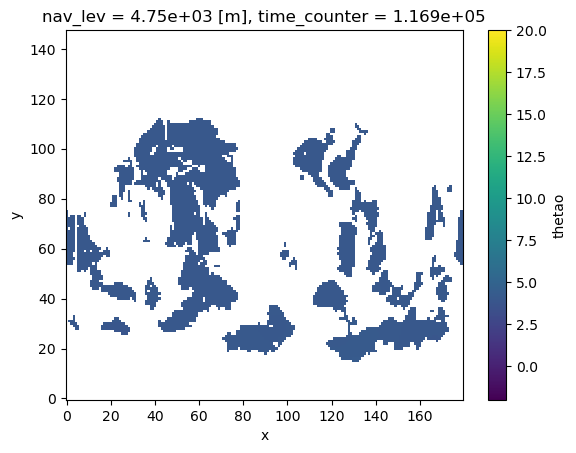

In [9]:
data['thetao'].isel(time_counter=0,nav_lev=29).plot(vmin=-2,vmax=20)

In [11]:
ds = xr.where( data[var] < -1.8, 2, data[var])

(-2.0, 0.0)

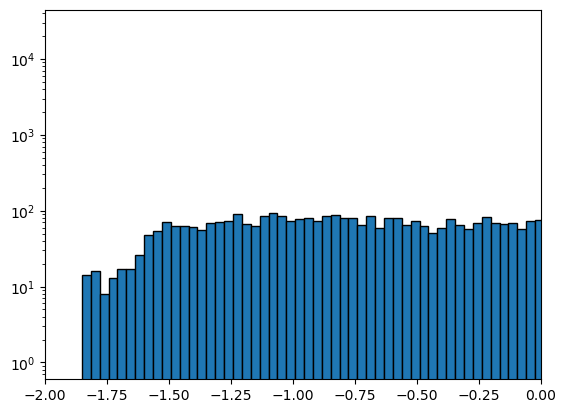

In [21]:
plt.hist(data[var].values.flatten(), bins=1000, edgecolor='black')
plt.yscale('log')
plt.xlim(-2,0)

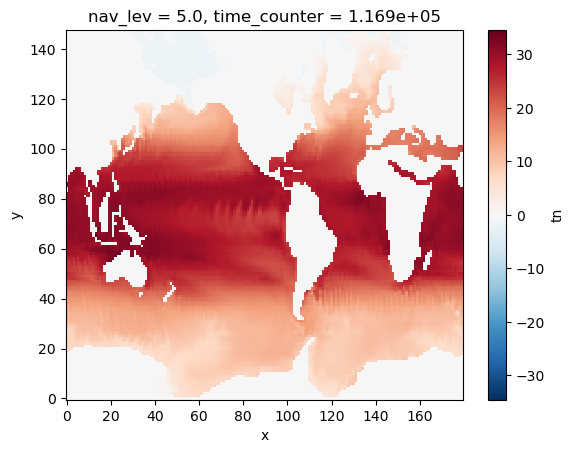

In [23]:
rdata['tn'].isel(time_counter=0,nav_lev=0).plot()

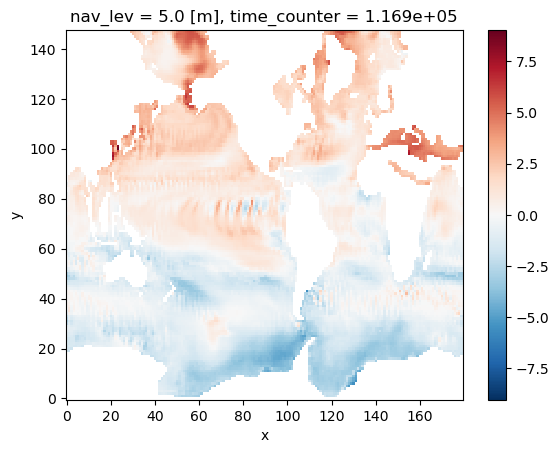

In [4]:

delta = data['thetao'] - rdata['tn']
delta.isel(nav_lev=0,time_counter=0).plot()

In [5]:
varlist = ['tn', 'tb']
for var1 in varlist: 
    rdata[var1] = data['thetao']

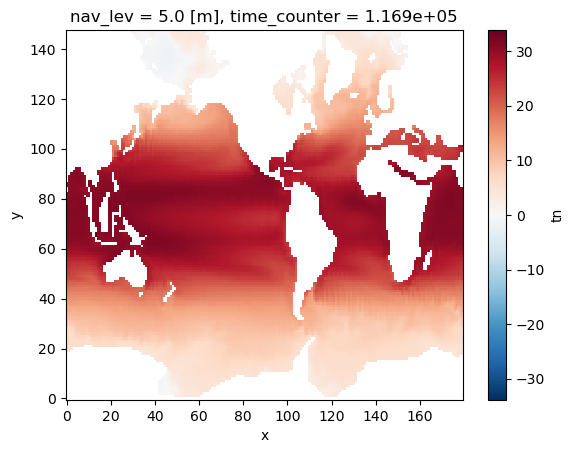

In [6]:
rdata['tn'].isel(nav_lev=0,time_counter=0).plot()